<a href="https://colab.research.google.com/github/marcosarto/titanicML/blob/main/neural_nets/neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Evito scritte questa funzione verra' deprecata ecc
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TensorFlow (e keras al di sopra)
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [16]:
marcello = pd.read_csv('https://raw.githubusercontent.com/marcosarto/titanicML/main/neural_nets/processed_test.csv')
marcello = marcello.astype(float)
    
data = pd.read_csv('https://raw.githubusercontent.com/marcosarto/titanicML/main/neural_nets/processed_train.csv')

## Scalo i dati tra 0 - 1

Sottraggo la media e divido per la deviazione standard

In [17]:
def scale_data(X_train, X_test):
    "Scalo i dati tra 0-1 in base al loro valore nel dataframe"
    
    sc = MinMaxScaler()

    sc.fit(X_train)

    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Load data

In [18]:
# Pongo i dati a float (per fare poi la normalizzazione)
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # Colonne PassengerId inutile, survived viene salvata in y
y = data['Survived']

In [19]:
marcello.drop('PassengerId', inplace=True, axis=1)
marcello['Embarked_missing']=marcello['EmbarkedImputed'].values
marcello['CabinLetter_T']=marcello['CabinLetter_F'].values

# Creo la rete neurale



In [20]:
def make_net(number_features, 
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.0, 
             learning_rate=0.003):
    
    # Forse non più necessario, pulisce eventuali rimanenze
    K.clear_session()
    
    # Creo una neural completamente connessa
    net = Sequential()
    
    # For che crea gli strati
    for i in range(hidden_layers):
        # Tutti gli strati usano ReLu come funzione di attivazione tranne l'output
        net.add(Dense(
            hidden_layer_neurones, 
            input_dim=number_features,
            activation='relu'))
        # Trattamento dell'overfit con dropout (lo aggiungo dopo ogni layer)
        # Potrei usare anche tecniche che lo mettono solo in alcuni layers
        net.add(Dropout(dropout))
    
    # Vogliamo una percentuale (vivo/morto) => sigmoide
    net.add(Dense(1, activation='sigmoid'))    
    
    # Sclego adam come scritto nella relazione perchè.
    # In sostanza è generalmente il migliore
    opt = Adam(lr=learning_rate)
    
    # Funzione di loss compatibile con il problema di classificazione a 2 valori
    #accuracy per poter giudicare come farebbe kaggle
    net.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    
    return net

## Split and Scale data

In [21]:
# Divido tra train e validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state=42)

# Scalo tra 0 e 1
X_train_sc, X_test_sc = scale_data(X_train, X_test)

In [22]:
sc = MinMaxScaler()

# Set up the scaler just on the training set
sc.fit(marcello)

# Apply the scaler to the training and test sets
marcello_sc = sc.transform(marcello)
    

## Cerco di copiare una funzione di valutazione tipo kaggle (accuracy)

In [23]:
def calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test):  
    
    ### Accuracy del train
    probability = model.predict(X_train_sc)
    y_pred_train = probability >= 0.5
    #Serve solo per rendere l'array di dimensione che ci aspettiamo,
    #Tensorflow mi da in output qualcosa non uno dimensionale
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    
    ### Accuracy del validation
    probability = model.predict(X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)

    print (f'Training accuracy {accuracy_train:0.3f}')
    print (f'Test accuracy {accuracy_test:0.3f}')

In [24]:
def plot_training(history_dict):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Train-set acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation-set accuracy')
    plt.title('Prestazioni dell\' accuracy')
    plt.xlabel('Epoche')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Run the model

In [25]:
number_features = X_train_sc.shape[1]
model = make_net(number_features) #I parametri non definiti useranno val default

history = model.fit(X_train_sc,
                    y_train,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

In [26]:
calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy 0.921
Test accuracy 0.776


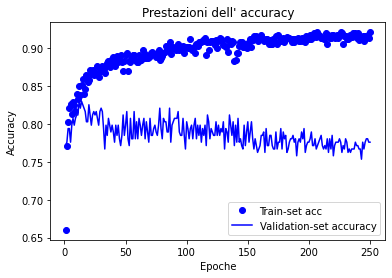

In [27]:
plot_training(history.history)

## Provo a ridurre l'overfit

### 1) Alleggerisco il modello


In [28]:
number_features = X_train_sc.shape[1]
model = make_net(number_features,
                hidden_layers=1,
                hidden_layer_neurones=32)

history = model.fit(X_train_sc,
                    y_train,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

In [29]:
calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy 0.873
Test accuracy 0.803


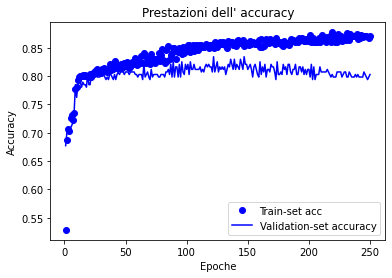

In [30]:
plot_training(history.history)

### 2) Mi fermo prima con le epoche

In [31]:
number_features = X_train_sc.shape[1]
model = make_net(number_features)

history = model.fit(X_train_sc,
                    y_train,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

In [32]:
calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy 0.880
Test accuracy 0.794


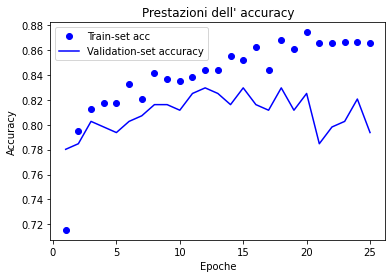

In [33]:
plot_training(history.history)

### 3) Aggiungo i dropout

In [34]:
number_features = X_train_sc.shape[1]
model = make_net(number_features,
                dropout=0.5)

history = model.fit(X_train_sc,
                    y_train,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

In [35]:
calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy 0.889
Test accuracy 0.803


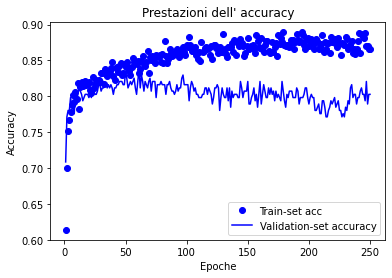

In [36]:
plot_training(history.history)

### 5) Unisco varie tecniche sopra, più mi faccio aiutare da keras per interrompere quando raggiungo il picco (aggiungendo un piccolo momentum per non fermarmi in un minimo locale)

In [37]:
# Chiedo a keras di fermarsi quando trova un massimo
# Provo 25 epoche dopo il massimo per verificare di non essere in un max locale
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True)

number_features = X_train_sc.shape[1]
model = make_net(
    number_features,
    hidden_layers=2,
    hidden_layer_neurones=64,
    dropout=0.3)

history = model.fit(X_train_sc,
                    y_train,
                    epochs=250,
                    batch_size=64,
                    validation_data=(X_test_sc, y_test),
                    verbose=0,
                    callbacks=[early_stopping_cb])

In [38]:
calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy 0.834
Test accuracy 0.816


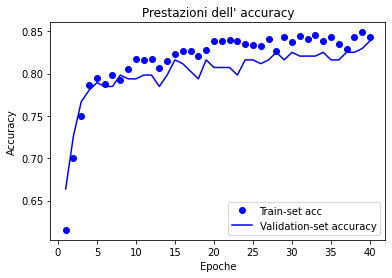

In [39]:
plot_training(history.history)

## Salvo il modello (colab lo cancella bisogna scaricarlo)

In [40]:
model.save('titanic_tf_model.h5')

# Load and use saved model - we need to first set up a model
restored_model = keras.models.load_model('titanic_tf_model.h5')
 
# Predict classes as normal
predicted_proba = restored_model.predict(X_test_sc)

# Show examples of predicted probability
print(predicted_proba[0:5].flatten())

[0.11434048 0.1556178  0.15965861 0.8417213  0.6675542 ]


In [41]:
calculate_accuracy(restored_model, X_train_sc, X_test_sc, y_train, y_test)

Training accuracy 0.834
Test accuracy 0.816


In [44]:
sub = pd.DataFrame(columns=['PassengerId','Survived'])
prova=pd.read_csv('https://raw.githubusercontent.com/marcosarto/titanicML/main/neural_nets/test.csv')
passengerId=prova['PassengerId']
probability = restored_model.predict(marcello_sc)
y_test_pred = probability.flatten()
y_test_pred = np.around(y_test_pred)
y_test_pred = y_test_pred.astype(int)
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': y_test_pred})
kaggle.to_csv('Neural.csv', index=False)